### 參考資料

-[打开人工智能的黑盒子](https://zhuanlan.zhihu.com/p/58099941) 
  - 从效果上看，PatternNet 和 PatternAttribution 方法效果最好。在文章THE (UN)RELIABILITY OF SALIENCY METHODS中，作者发现除了 PatternAttribution 方法，其他方法都对输入非常敏感。比如在所有输入图片中添加固定的可作背景的色块，原则上不应该改变 Saliency Map的输出结果，但现实是除了 PatternAttribution 方法，其他方法产生的 Saliency Map 基本都被破坏。所以如果要使用 Saliency Map，首推 PatternNet 和 Pattern Attribution。  
  
-['模型解释 -- Guided-Backpropagation、CAM、Grad-CAM、Grad-CAM++ 及 pyTorch Hook'](https://blog.csdn.net/cdknight_happy/article/details/108792065)  
-[浅谈Class Activation Mapping（CAM）](https://zhuanlan.zhihu.com/p/51631163)  
-[万字长文：特征可视化技术(CAM)](https://zhuanlan.zhihu.com/p/269702192)  
-[誰說鼻子長的就是大象？從類別活化映射與積分梯度來看特徵提取與顯著性差異](https://aihub.org.tw/platform/specialist/article/277f31d6-0172-11eb-8350-0242ac120002) 
  - gradient-based:
    - Grad-CAM (2016.10)
    - Grad-CAM++ (2017.10)
    - Smooth Grad-CAM++ (2019.08)
  - gradient-free:
    - CAM (2015.12)
    - score-CAM (2019.10)
    - ss-CAM (2020.06)
    - Ablation-CAM (2020)

-[ML 李弘毅hw5](https://colab.research.google.com/drive/1mOl6u7dAlXcVUoFtSsohawSOoUdFai7b#scrollTo=6Z9o2c3jTlwG)  
-[2021ML HW9 Explainable AI](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW09/HW09.ipynb#scrollTo=leWC9kKgL55n)

### Github

-[yizt/Grad-CAM.pytorch](https://github.com/yizt/Grad-CAM.pytorch)

# 蛾類資料準備

In [1]:
import time, os, sys, glob, argparse
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('seaborn-white')
# import seaborn as sns
# sns.set(style='white', context='notebook', rc={'figure.figsize':(12,10)})

path_root =  '/home/jovyan/Autoencoder'

path_EXAI =  f"{path_root}/EXAI_Visualization"
if not os.path.isdir(f'{path_EXAI}'):
    os.mkdir(f'{path_EXAI}')
    print(f'"{path_EXAI}" folder made!')

In [2]:
sys.path.append("..")  # 更改預測的import路徑，為了能讀取上一層級資料夾 MothScripts內的檔案
from MothScripts.resnet50_classifier import ResNet50_family_classifier
import skimage
import skimage.io
import skimage.transform

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [4]:
# resnet50 = ResNet50_family_classifier(getDeepFeature=False).to(device)                        # getDeepFeature=False for get prediction only(else for feature map)

# # Load pth
# resnet_pretrained = torch.load(
#     "../model/vsc_wgan/pretrained_fam_classification_resnet50_20210613.pth", 
#     map_location=lambda storage, loc: storage.cuda(1)                                         # optoonal 將model從原本預設的讀取位置指定到cuda(1) 
# )
# pretrained_dict, resnet50_dict = resnet_pretrained['model_state'], resnet50.state_dict()      # 載入權重參數
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in resnet50_dict}            # 更新pretrained model的key與value，使之與resnet50一致
# resnet50_dict.update(pretrained_dict)                                                         # 將resnet50的權重更新為pretrained model
# resnet50.load_state_dict(resnet50_dict)                                                       # 將pretrained的權重載入resnet50

In [5]:
# # 評估模型摘要
# from torchsummary import summary
# device = torch.device("cpu")
# input_size = (3, 128, 128)
# batch_size = 1

# summary(resnet50.to(device), input_size=input_size, batch_size=batch_size, device='cpu')

In [6]:
metadata = f'{path_root}/meta/moth_meta_20210610.csv'
moth_meta = pd.read_csv(metadata)
# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_meta['ImgPath'] = image_list

fam_dict = dict(
    zip(range(90), np.sort(moth_meta.Family.unique())
    ) 
) 

In [7]:
# 讀取benchmarks
metadata = f'{path_root}/meta/moth_benchmarks_meta_20210709.csv'
moth_bh_meta = pd.read_csv(metadata)
# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/benchmarks"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_bh_meta['ImgPath'] = image_list

In [8]:
class ImgDataset(Dataset):
    '''簡單用來抽樣看原始圖檔的Dataset
        X: ImagePath
        y: Imagelabel(Family, Genus ,Specie Name etc...)
    '''
    def __init__(self, X, Y):
        self.ImgNames  = np.asarray(X)                # 輸入的X 為影像完整路徑的list、y則為完整的科名list 
        self.labels = np.asarray(Y).astype("uint8")
        self.to_tensor = transforms.ToTensor()        # 將取值範圍為[0, 255]的PIL.Image或形狀為[H, W, C]的numpy.ndarray，轉換成形狀為[C, H, W]，取值範圍是[0, 1.0]的torch.FloadTensor
#         self.transform = transforms.Compose([       # 影像必須用PIL開啟才能使用transforms.Compose等系列操作
#             transforms.Resize(size=(128, 128)),
#             transforms.ToTensor()
#         ])
        
    def __getitem__(self, index):
        img_Name = self.ImgNames[index]
#         image = PILImage.open(img_Name)                #  PIL Image讀讀取影像的通道為(c,w,h)
        image = skimage.io.imread(img_Name)              #  skimage.io讀取影像的通道為(w,h,c)，to_tensor會自動調整  
        image = skimage.transform.resize(image, (256,256))
        image = self.to_tensor(image)                    # 根據檔名開啟影像。得到image.jpg的物件，並轉為Tensor
        label  = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

In [9]:
# 一次預讀取讀取所有影像 
X = moth_meta.ImgPath
Y = moth_meta.Family_encode
img_set = ImgDataset(X=X, Y=Y)
class_names = moth_meta.Family  # Series

In [10]:

# 一次預讀取讀取所有bencemarks影像 
X_bh = moth_bh_meta.ImgPath
Y_bh = moth_bh_meta.Family_encode
img_bh_set = ImgDataset(X=X_bh, Y=Y_bh)
class_names = moth_bh_meta.Family  # Series

# register backward hook

In [11]:
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(3, 4)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(4, 1)
#         self.initialize()

#     def initialize(self):
#         with torch.no_grad():
#             self.fc1.weight = torch.nn.Parameter(
#                 torch.Tensor([[1., 2., 3.],
#                               [-4., -5., -6.],
#                               [7., 8., 9.],
#                               [-10., -11., -12.]]))

#             self.fc1.bias = torch.nn.Parameter(torch.Tensor([1.0, 2.0, 3.0, 4.0]))
#             self.fc2.weight = torch.nn.Parameter(torch.Tensor([[1.0, 2.0, 3.0, 4.0]]))
#             self.fc2.bias = torch.nn.Parameter(torch.Tensor([1.0]))

#     def forward(self, x):
#         o = self.fc1(x)
#         o = self.relu1(o)
#         o = self.fc2(o)
#         return o

# total_grad_out = []
# total_grad_in = []

# def hook_fn_backward(module, grad_input, grad_output):
#     print('hook_fn_backward excuted !')
#     print(module) # 为了区分模块
#     # 为了符合反向传播的顺序，我们先打印 grad_output
#     print('grad_output', grad_output) 
#     # 再打印 grad_input
#     print('grad_input', grad_input)
#     # 保存到全局变量
#     total_grad_in.append(grad_input)
#     total_grad_out.append(grad_output)
#     print('-'*50)

# model = Model()

# modules = model.named_children()
# for name, module in modules:
#     print(name, module)
#     module.register_backward_hook(hook_fn_backward)

In [12]:
# # 这里的 requires_grad 很重要，如果不加，backward hook
# # 执行到第一层，对 x 的导数将为 None，某英文博客作者这里疏忽了
# # 此外再强调一遍 x 的维度，一定不能写成 torch.Tensor([1.0, 1.0, 1.0]).requires_grad_()
# # 否则 backward hook 会出问题。
# x = torch.Tensor([[1.0, 1.0, 1.0]]).requires_grad_()
# o = model(x)
# o.backward()

In [13]:
# print('==========Saved inputs and outputs==========')
# for idx in range(len(total_grad_in)):
#     print('grad output: ', total_grad_out[idx])
#     print('grad input: ', total_grad_in[idx])

# 實作Guided_backProp、GradCAM、GradCAMPlusPlus

In [ ]:
#coding=utf-8
# 注意opencv对于读进来的图片的通道排列是BGR，而不是主流的RGB！
import torch
import torch.nn as nn
import torchvision
import cv2
from PIL import Image
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
import json

In [ ]:
class Guided_backProp():
    def __init__(self, model):
        self.model = model
        #self.activations = []
        self.input_grad = None
        self.add_hook()

    # def forward_hook(self,module,input,output):
    #     self.activations.append(output)

    def backward_hook(self, module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], 0.),)

    def firstlayer_backward_hook(self, module, grad_in, grad_out):
        #对卷积层，grad_input = (对输入feature的导数，对权重 W 的导数，对 bias 的导数)
        #对全连接层，grad_input=(对 bias 的导数，对输入feature 的导数，对 W 的导数) 
        self.input_grad = grad_in[0]

    def add_hook(self):
        modules = list(self.model.named_children())

        for name, layer in modules:
            if isinstance(layer,nn.ReLU):
                # layer.register_forward_hook(self.forward_hook)
                layer.register_backward_hook(self.backward_hook)

        first_layer = modules[0][1][0]                            # for resnet50
        first_layer.register_backward_hook(self.firstlayer_backward_hook)

    def __call__(self, inputs, index=None, class_name=None):
        
        inputs = inputs.float().requires_grad_().to(device)
        
        self.model.eval()
        pred = self.model(inputs)
        self.model.zero_grad()
        
        pred = torch.nn.functional.softmax(pred, dim=1)
        pred_ = pred.argmax().item()
        
        if class_name != None:
            print("Prediction : ", fam_dict[pred_],"; True : ", class_name)
        if index == None:
#             val, index = torch.max(pred, dim=1)
            index = pred_

#         print(f"backward by {fam_dict[index]}")
#         print('预测结果:%s' %class_names[str(index.item())][1])

        one_hot = torch.zeros(pred.shape)
        one_hot[0][index] = 1

        #backward
        pred.backward(one_hot.to(device))  # torch.mul(pred, one_hot).sum().backward()
    
        # -------計算Saliency_map。
        saliency_map = self.input_grad[0].permute(1,2,0).cpu().numpy()

#         return saliency_map, False

        # ------繪製疊加原圖檔的熱力圖 
        img_heat_map = plot_heatmap(inputs[0].cpu().detach().numpy() , saliency_map, False)  # False :　不疊加原圖
        return img_heat_map

In [ ]:
class GradCAM():
    def __init__(self, model ,module_name, layer_name):
        self.model = model
        self.model.eval()
        self.module_name = module_name
        self.layer_name = layer_name
        
        self.features = None
        self.grad = None
        self.add_hook()

    def forward_hook(self, layer, inputs, output):
        self.features = output                                 # features.shape: torch.Size([1, 512, 7, 7])
    
    def backward_hook(self, layer, grad_in, grad_out):
        self.grad = grad_in[0]                                # grad.shape: torch.Size([1, 512, 7, 7])
        # 放in或out結果一致，len(gradin)=1
        
    def add_hook(self):
        for name_module, module in self.model.named_children():
            if name_module == self.module_name:
                for name_layer, layer in module.named_children():
                    if name_layer == self.layer_name:
                        layer.register_forward_hook(self.forward_hook)
                        layer.register_backward_hook(self.backward_hook)

    def __call__(self, inputs, index=None, class_name=None):
        self.model.eval()
        self.model.zero_grad()
        
        inputs = inputs.float().requires_grad_().to(device)
        pred = self.model(inputs)                               # pred.shape: torch.Size([1, 1000])
        pred_ = pred.argmax().item()
        
        if class_name != None:
            print("Prediction : ", fam_dict[pred_],"; True : ", class_name)
        
        if index == None:
#             val, index = torch.max(pred, dim=1)
            index = pred_
#         print(f"backward by {fam_dict[index]}")

        # 將y轉為預測值類別為1，其他預測類別全為0，然後求導，這時候可得該類別反向傳播的導數及特徵圖
        one_hot = torch.zeros(pred.shape).to(device)
        one_hot[0][index] = 1 
        pred.backward(one_hot)  # 應該等同於逐元素相乘後得到的純量再丟進backward()。   torch.mul(pred, one_hot).sum().backward() 
        # z.sum().backward() == z.backward(torch.ones_like(z)) 亦即 sum(Z) = dot(Z, I)。 對z求和等價於 z點乘一個一樣维度、全为1的單位矩陣

        
        # --------計算各特徵圖的權重，依據對該類別的導數(微分值)
        # 對梯度做 global average pooling，得到該類別的權重
        # 將grad()形狀轉為torch.Size([1, 512, 49])後，等同grad.flatten(start_dim=2)，針對第2維求平均
        # 這邊的w是指特徵圖的權重，等同於CAM或GradCAM++的alpha
        # w 經過 Global average pooling以後，變為單一數值，也藉是說將該特徵圖的權重轉變為單一值
        
        w_c = torch.mean(
            self.grad.view(self.grad.shape[0], self.grad.shape[1], -1),
            dim=2
        )

#         w_c = torch.mean(self.grad.flatten(start_dim=2), dim=2)  # 同上一行
        # w_c.shape:  torch.Size([1, 512])
        
        
        # -------計算Final Class discriminative Saliency_map。此處的outputs 即為CAM(Classification Activation Mapping)
        #  weight_of_feature * features(Last Layer) 特徵的權重， 逐元素與特徵圖相乘(n=512,權種值轉換為1*1， 特徵圖尺寸=7*7)
        saliency_map = w_c[0].view(-1, 1 ,1) * self.features[0]       # [512,1,1] * [512,7,7] => torch.Size([512, 7, 7])。             # 
        saliency_map = torch.clamp(saliency_map, min=0.)              # 等同relu的效果， 等同numpy的np.maximum(cam, 0)，去掉特徵圖中的負值
        saliency_map = torch.sum(saliency_map, dim=0)                 # output.shape after Sum: torch.Size([7, 7])　　　　　　　　
        saliency_map = saliency_map.cpu().detach().numpy()
#         return saliency_map, True

        # ------繪製疊加原圖檔的熱力圖 
        img_heat_map = plot_heatmap(inputs[0].cpu().detach().numpy() , saliency_map, True)  # True :　疊加原圖
        return img_heat_map

class GradCAMPlusPlus(GradCAM):
    def __call__(self, inputs, index=None, class_name=None):
        self.model.eval()
        self.model.zero_grad()

        inputs = inputs.float().requires_grad_().to(device)
        pred = self.model(inputs)
        pred_ = pred.argmax().item()

        if class_name != None:
            print("Prediction : ", fam_dict[pred_],"; True : ", class_name)
        if index == None:
#             val, index = torch.max(pred, dim=1)
            index = pred_

#         print(f"backward by {fam_dict[index]}")

        one_hot = torch.zeros(pred.shape).to(device)
        one_hot[0][index] = 1

        pred.backward(one_hot)

         # --------計算各特徵圖的權重，依據對該類別的導數(微分值)
         #  相對GradCam，GradCam++ 認為梯度map上的每個元素貢獻不同
         #  因此增加了一個额外的權重對梯度map上的元素进行加權(用到了二階與三階偏導)
        grad = torch.clamp(self.grad, min=0.)  
        
        alpha_num = self.grad.pow(2)
        alpha_denom = 2 * alpha_num + (self.features
                                       .mul(self.grad.pow(3))
                                       .view(self.features.shape[0], self.features.shape[1], -1)
                                       .sum(dim=2)
                                       .view(self.features.shape[0], self.features.shape[1], 1, 1)
                                      )
                      
        alpha = alpha_num / (alpha_denom + 1e-8)
        weights = (alpha * grad).view(alpha.shape[0], alpha.shape[1], -1).sum(dim=2)
        
        # -------計算Final Class discriminative Saliency_map。
        saliency_map = (weights.view(weights.shape[0], weights.shape[1], 1, 1) * self.features).sum(dim=1)
        saliency_map = torch.clamp(saliency_map, 0.)  #等同relu的效果， 等同numpy的np.maximum(cam, 0)
        saliency_map = saliency_map[0].cpu().detach().numpy()  # saliency_map.shape after Sum: torch.Size([1, 7, 7])　  
#         return saliency_map, True

        # ------繪製疊加原圖檔的熱力圖 
        img_heat_map = plot_heatmap(inputs[0].cpu().detach().numpy() , saliency_map, True)
        return img_heat_map


def plot_heatmap(img_origin, saliency_map, bAdd):
    # 注意，這邊的影像形狀應該是 (W,H,C)、且C色彩的順序應該是RGB，若是使用opencv則須注意其讀入順序是BGR
    # bAdd : Boolean。 是否疊加原圖
    size = img_origin.shape[1:]    
    if bAdd:
        saliency_map = (saliency_map - saliency_map.min()) / saliency_map.max()
        image = np.array(img_origin).astype(np.float)
#         rez_img = cv2.resize(saliency_map, (img_origin.size[0], img_origin.size[1]))        # upsampling CAM to image size。Img.size=(320,214)  
        rez_img = cv2.resize(saliency_map, size)
        rez_img = (rez_img * 255).astype(np.uint8)
        
        heatmap = cv2.applyColorMap(rez_img, cv2.COLORMAP_JET).astype(np.float)
        heatmap /= 255.
        heatmap = heatmap[:,:,::-1]                                            #  "BGR" to "RGB" for opencv   
        result = heatmap + np.transpose(image, (1,2,0))   #  (c, h, w) > (h, w ,c)
        result = result / result.max()
    else:
        #归一化input_grad
        saliency_map = (saliency_map - saliency_map.mean()) / saliency_map.std()
        saliency_map *= 0.1
        saliency_map += 0.5
#         input_grad = cv2.resize(saliency_map, (img_origin.size[0], img_origin.size[1]))
        saliency_map = cv2.resize(saliency_map, size)
        result = saliency_map.clip(0,1)

    return result

In [ ]:
# benchmarks
images, labels = img_bh_set.getbatch(range(30))
# print(img_indices)
print(labels)
print([fam_dict[label.item()] for label in labels])

In [ ]:
# images, labels = img_set.getbatch([9921])
# label = labels[0].item()
# class_name = fam_dict[label]
# print(class_name)

# images.requires_grad_()

# mean = [0.6723, 0.6369, 0.5937]
# std = [0.2060, 0.2210, 0.2488]
# transfer = transforms.Compose([transforms.Normalize(mean,std)])
# Img_trans = transfer(images[0]).unsqueeze(0).requires_grad_().float().to(device)

# resnet50.eval()
# with torch.no_grad():
#     pred  = resnet50(images.float().to(device))
# pred_ = pred.argmax().item() ; label = labels[0].item()
# print("Prediction : ", fam_dict[pred_],"; True : ", fam_dict[label])
# plt.imshow(images[0].permute(1,2,0).cpu());

In [ ]:
resnet50.conv5_x[2]

In [ ]:
gb = Guided_backProp(resnet50)
gradCam = GradCAM(resnet50, 'conv5_x', '2')                     # 指定神經網路最後一層
gradCamPlus = GradCAMPlusPlus(resnet50, 'conv5_x', '2')

gb_Img, gradCam_Img, gradCamPlus_Img = None, None, None
for i, image in enumerate(images):
    image = image.unsqueeze(dim=0).float().requires_grad_().to(device)   # Guided_backProp需要保留輸入值的積分
    if i ==0:
        gb_Img = np.expand_dims(gb(image), axis=0)
        gradCam_Img = np.expand_dims(gradCam(image), axis=0)
        gradCamPlus_Img = np.expand_dims(gradCamPlus(image), axis=0)
        
    else:
        gb_Img =  np.vstack((gb_Img, np.expand_dims(gb(image), axis=0)))
        gradCam_Img =  np.vstack((gradCam_Img, np.expand_dims(gradCam(image), axis=0)))
        gradCamPlus_Img =  np.vstack((gradCamPlus_Img, np.expand_dims(gradCamPlus(image), axis=0)))

    print("gb_Img : ", gb_Img.shape, end="\r")
    print("gradCam_Img : ", gradCam_Img.shape, end="\r")
    print("gradCamPlus_Img : ", gradCamPlus_Img.shape, end="\r")

In [ ]:
methods = ["Guided_backProp", "GradCAM", "GradCAMPlusPlus"]
for method in methods:     

    if method == "Guided_backProp":
        visual_method = gb_Img
    if method == "GradCAM":
        visual_method = gradCam_Img
    if method == "GradCAMPlusPlus":
        visual_method = gradCamPlus_Img
    print(method)


    images_ = images.permute(0, 2, 3, 1)                # 調整原影像格格式  (batchm,c, w, h) > (batchm, w, h, c)
    fig, axs = plt.subplots(2*3, 10, figsize=(25, 16))
    for row, target in enumerate([images_[:10], visual_method[:10], images_[10:20], visual_method[10:20], images_[20:30], visual_method[20:30]]):
        for column, img in enumerate(target):
            axs[row][column].imshow(img)

    fig.suptitle(f"Benchmarks_{method}", y=0.9, fontsize=24)
    fig.savefig(f'{path_EXAI}/Benchmarks_{method}', bbox_inches='tight')

# Smooth grad

Smooth grad 的方法是，在圖片中隨機地加入 noise，然後得到不同的 heatmap，把這些 heatmap 平均起來就得到一個比較能抵抗 noisy gradient 的結果。

The method of Smooth grad is randomly adding noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

### 修正
- 每次epoch前讓模型的梯度歸零
- 原本的x_mod 採用abs()取絕對值，改為取relu去掉負值的積分(化為0)，去掉躁訊

In [19]:
# Smooth grad

def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
    model.eval()
    #x = x.cuda().unsqueeze(0)

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
    smooth = np.zeros((x).unsqueeze(0).size())
    for i in range(epoch):
        # call Variable to generate random noise
        model.zero_grad()
        noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
        x_mod = (x + noise).unsqueeze(0).to(device)
        x_mod.requires_grad_()
        
        y_pred = model(x_mod)
#         y_pred, *_ = model(x_mod)

        loss_func = torch.nn.CrossEntropyLoss()
        loss = loss_func(y_pred, y.to(device).unsqueeze(0))
        loss.backward()

        # like the method in saliency map
#         x_mod  = torch.clamp(x_mod.grad, min= 0.)           # relu (reserve positive)
        x_mod  = torch.clamp(x_mod.grad, max= 0.)           # relu (reserve positive)
#         x_mod  = x_mod.grad.abs()                           # get absolute
        smooth += x_mod.detach().cpu().numpy()
    smooth = normalize(smooth / epoch) # don't forget to normalize
    # smooth = smooth / epoch
    return smooth

In [11]:
# img_indices =  np.random.randint(y.size, size=8)
# img_indices = np.arange(8)
# img_indices = moth_meta[moth_meta.Fam_Specie<10][:8].index
images, labels = img_bh_set.getbatch(np.arange(30))
# print(img_indices)
print(labels)

tensor([ 1,  1,  3, 10, 19, 27, 34, 39, 39, 48, 48, 48, 48, 48, 61, 61, 61, 61,
        61, 61, 61, 61, 64, 65, 65, 74, 79, 79, 89, 89])


In [20]:
# images, labels = train_set.getbatch(img_indices)
epoch = 50
model = resnet50
smooth = []
for i, l in zip(images, labels):
    smooth.append(smooth_grad(i.float(), l, model, epoch, 0.4))
smooth = np.stack(smooth)
print(smooth.shape)

(30, 1, 3, 224, 224)


In [22]:
smooth_p = smooth 

In [21]:
epoch = 50
model = resnet50
smooth_n = []
for i, l in zip(images, labels):
    smooth_n.append(smooth_grad(i.float(), l, model, epoch, 0.4))
smooth_n = np.stack(smooth_n)

In [25]:
smooth =  (smooth_p + smooth_n)/2 
print(smooth.shape)

(30, 1, 3, 224, 224)


In [ ]:
print("Benchmarks")
method = "SmoothGrad"

fig, axs = plt.subplots(2*3, 10, figsize=(25, 16))
for row, target in enumerate([images[:10], smooth[:10], images[10:20], smooth[10:20], images[20:30], smooth[20:30]]):
    for column, img in enumerate(target):
        axs[row][column].set_axis_off()
        axs[row][column].imshow(np.transpose(img.reshape(3, 224, 224) , (1,2,0)))
fig.suptitle(f"Benchmarks_{method}_{epoch}", y=0.9, fontsize=24)
fig.savefig(f'{path_EXAI}/Benchmarks_{method}_{epoch}_pn', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2, len(img_indices), figsize=(25, 6))
for row, target in enumerate([images, smooth]):
    for column, img in enumerate(target):
        axs[row][column].imshow(np.transpose(img.reshape(3, 224, 224) , (1,2,0)))

# Integrated Gradient

In [ ]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(device)
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

In [ ]:
# put the image to cuda
img_indices = range(30)
images, labels = img_bh_set.getbatch(img_indices)
# images = images.float().to(device)

In [ ]:
step = 10
IG = IntegratedGradients(resnet50)
integrated_grads = []
for i, img in enumerate(images):
    img = img.unsqueeze(0).float().to(device)
    integrated_grad = IG.generate_integrated_gradients(img, labels[i], step)
    integrated_grads.append(normalize(integrated_grad))

In [ ]:
print("Benchmarks")
method = "IntegratedGradient"

visual_method = integrated_grads
# images_ = images.permute(0, 2, 3, 1)                # 調整原影像格格式  (batchm,c, w, h) > (batchm, w, h, c)
images_ = images.numpy()

fig, axs = plt.subplots(2*3, 10, figsize=(25, 16))
for row, target in enumerate([images_[:10], visual_method[:10], 
                              images_[10:20], visual_method[10:20], 
                              images_[20:30], visual_method[20:30]]):
    for column, img in enumerate(target):
        axs[row][column].imshow(np.moveaxis(img, 0, -1))  # 把第0軸搬移到最後一軸 (batchm,c, w, h) > (batchm, w, h, c)

fig.suptitle(f"Benchmarks_{method}_step{step}", y=0.9, fontsize=24)
fig.savefig(f'{path_EXAI}/Benchmarks_{method}_step{step}', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2, len(img_indices), figsize=(24, 4))
for i, img in enumerate(images):
    axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
    axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()

# Filter explanation

In [ ]:
def normalize(image):
    image = image.float()
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, res_blocks=None,  filterid=None, iteration=100, lr=1):
    # x: input image
    # res_blocks = "conv1"、"conv2_x"、"conv3_x"、"conv4_x"、"conv5_x"
    # cnnid, filterid: cnn layer id, which filter
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
  
    hook_handle = res_blocks.register_forward_hook(hook)
    # When the model forward through the layer[cnnid], need to call the hook function first
    # The hook function save the output of the layer[cnnid]
    # After forwarding, we'll have the loss and the layer activation

    # Filter activation: x passing the filter will generate the activation map
    model(x.to(device) ) # forward

    # Based on the filterid given by the function argument, pick up the specific filter's activation map
    # We just need to plot it, so we can detach from graph and save as cpu tensor
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

    # Filter visualization: find the image that can activate the filter the most
    x = x.to(device) 
    x.requires_grad_()
    # input image gradient
    optimizer = Adam([x], lr=lr)
    # Use optimizer to modify the input image to amplify filter activation
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)

        objective = -layer_activations[:, filterid, :, :].sum()
        # We want to maximize the filter activation's summation
        # So we add a negative sign

        objective.backward()
        # Calculate the partial differential value of filter activation to input image
        optimizer.step()
        # Modify input image to maximize filter activation
    filter_visualizations = x.detach().cpu().squeeze()

    # Don't forget to remove the hook
    hook_handle.remove()
    # The hook will exist after the model register it, so you have to remove it after used
    # Just register a new hook if you want to use it

    return filter_activations, filter_visualizations

In [ ]:
# img_indices =  np.random.randint(y.size, size=8)
# images, labels = img_set.getbatch(img_indices)
images, labels = img_set.getbatch(range(8))
# print(img_indices)
print(labels)

In [ ]:
res_blocks = resnet50.conv1[-1]
filterid = -1
filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
print(res_blocks)
print(layer_activations.shape)

In [ ]:

fig, axs = plt.subplots(3, len(labels), figsize=(18, 6))
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
# plt.close()

# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

In [ ]:
def plot_features():
    fig, axs = plt.subplots(2, len(labels), figsize=(15, 3))
    # Plot filter activations
    for i, img in enumerate(filter_activations):
        axs[0][i].imshow(normalize(img))
    # Plot filter visualization
    for i, img in enumerate(filter_visualizations):
        axs[1][i].imshow(normalize(img.permute(1, 2, 0)))

In [ ]:
res_blocks = resnet50.conv1[-1]
filterid = -1
#  layer_activations.shape :　torch.Size([8, 256, 32, 32])
for f in range(10):
    filterid = f
    filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
    plot_features()
print(layer_activations.shape)

In [ ]:
res_blocks = resnet50.conv2_x[-1]
filterid = -1
#  layer_activations.shape :　torch.Size([8, 256, 32, 32])
for f in range(10):
    filterid = f
    filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
    plot_features()
print(layer_activations.shape)

In [ ]:
res_blocks = resnet50.conv3_x[-1]
filterid = -1
for f in range(10):
    filterid = f
    filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
    plot_features()
print(layer_activations.shape)

In [ ]:
res_blocks = resnet50.conv４_x[-1]
filterid = -1
for f in range(10):
    filterid = f
    filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
    plot_features()
print(layer_activations.shape)

In [ ]:
res_blocks = resnet50.conv５_x[-1]
filterid = 0
for f in range(10):
    filterid = f
    filter_activations, filter_visualizations = filter_explanation(images.float(), resnet50, res_blocks=res_blocks, filterid=filterid, iteration=100, lr=0.1)
    plot_features()
print(layer_activations.shape)

# 蛾類分群視覺化、模型分科的判斷依據在哪?
## 操作指引
- ResNet50 分科分屬分種實驗 https://docs.google.com/document/d/16ve8AoRv1FFhN-yWH--PrNo_hL4gURGqYBYqhvw0-yc/edit?usp=sharing

### LRP視覺化、LRP分群視覺化 電腦都在看哪?
- LRP pytorch implementation https://github.com/dmitrysarov/LRP_decomposition
- 將 validating + testing dataset 與訓練好的模型過一遍 LRP，會得到每張照片的 rgb-channel heatmap (經過 customized standard normalization)，與轉換為灰階的 mask。
- 為了將資料控制在可操作的尺度，我們將 2D (256, 256) 灰階資料以 opencv resize with default 縮放為 (64, 64)，而後 reshape 成 1D (4096) 再進行後續降維分群操作。
- 降維採用 UMAP 演算法，distance metric 則採用 correlation 而非歐式距離。random_state=1
- 採用 density-based 不需要指定分群數的 OPTICS 分群演算法，抓出模型的關注點。
- 為了減少物種樣本數對資料密度的影響，我們在種平均值上進行分群，min_cluster_size 定為 10，共分出 36 群。從每群可看出電腦關注蛾標本各部位的形狀、大小等特徵。

## Note:  
### 目的  
- 檢視蛾類分科模型的關注重點

### 方法  
- 原方案
  - 先取得所有標本照的 SaliencyMap 
  - 將取得的SaliencyMap進行降維後分群 
    - 檔案處理(2D > 1D Vector)
      - 以灰階格式儲存
      - 尺寸從 256X256 縮小為 64X64 
      - 再將2D(64,64)轉為1D(4096)
      - 降維(PCA、UMAP...)，取得降維後的張量
        - UMAP。注意使用的參數，檢視降維後的資料分布、測試參數使用
      - 使用降維後的資料進行分群(DBSCAN、OPTICS, etc...)
        - 檢視不同方法 以及不同參數設定
    - 取得分群後的特徵值中心點位置，反降維回推原本形狀、檢視分群後的SaliencyMap
    
#### 7/16 討論筆記
- cam家族的解析度不夠(因為是採用最後一層特徵圖疊加，而最後的特徵圖尺寸大約為7*7，因此無法取得足夠細緻的解析度)
  - 需要採用能看出比較細緻差異的視覺化方式、LRP或其他方式，如smoothgrad等
- 縮放時 注意縮小時的演算法、避免失真 (可參考opencv等工具)
- 做完所有資料後、可以科獨立出來看
- 挑出小樣本、但分類正確率高的科別檢視是否有看對正確的位置
    
#### 7/27 
- 取得3,2262筆標本照片的saliency map，採用Smooth_grad(epoch=100, sigma=0.4)
  - 資料儲存為png(避免使用jpg破壞性壓縮)，彩色照
    - 大小每張約150KB、合計約5.5G
    - 每張saliency map對應原檔名命名
  - 原Smooth_grad得作法是取積分的絕對值，在蛾類資料集中經過測試，發現取Relu(過濾負值、保留正值)過濾雜訊的效果較佳，這也是多數Cam的作法

In [14]:
# ----Convert Saliency may to Grey and Resize---------------------------------------------------------------------------------
import cv2
# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/EXAI_Visualization/SaliencyMap_SmoothGrad"
smoothImg_list = glob.glob(dataroot + '/*.png')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_meta['SmoothImgPath'] = smoothImg_list

In [10]:
# # Resize Algorith Test

# inter_dict = dict( zip(range(5), ["INTER_NEAREST", "INTER_LINEAR", "INTER_CUBIC", "INTER_AREA", "INTER_LANCZOS4"]))
# size =  (100, 100) #(112, 112)
# index=2
# Sci_Name = moth_meta.SciName[index]
# grey_origin = skimage.color.rgb2gray(images_[index])
# title = f"Resize{size}_Grey_{Sci_Name}"

# fig, axes = plt.subplots(3,5, figsize=(21,12))
# fig.suptitle(title, y=0.9, fontsize=24)
# for i, rows in enumerate(axes):
#     for j, ax in enumerate(rows):
#         if i==0 :
#             if j==0:
#                 ax.imshow(grey_origin, cmap='gray')
#                 ax.set_title("origin", {'fontsize':16})
#             else:
#                 ax.set_axis_off()
#         if i==1:
#             p = j*0.2
#             ax.imshow(skimage.transform.resize(grey_origin, size, anti_aliasing_sigma = p), cmap='gray')
#             ax.set_title(f"skimage anti_aliasing : {p:.1f}", {'fontsize':16})
#         if i==2:
#             ax.imshow(cv2.resize(grey_origin, size, j), cmap='gray')
#             ax.set_title(f"cv2 : {inter_dict[j]}", {'fontsize':16})
# fig.savefig(f"{path_EXAI}/{title}",bbox_inches="tight")

####  resize 演算法筆記
- cv2預設的LINEAR已經不錯 (官方建議的DOWNSAMPLE要用AREA 但各方法覺得沒有明顯差距
-  skiamage  預設(s=1.0)的不太好 ，參數要調到0.6以下才有較好效果
- 64,64 有些細緻的紋路已經消失(size/2以下)，不過用112,112跑分群不知是否跑得動(待測試)
- 影像轉為(1, 255) "uint8" (opencv)格式儲存可以有效減少記憶體使用量

In [15]:
# 一次預讀取讀取所有影像 
X_smooth = moth_meta.SmoothImgPath
Y = moth_meta.Family_encode
smoothImg_set = ImgDataset(X_smooth, Y)
class_names = moth_meta.Family  # Series

batch = 10
img_data_loader = DataLoader(smoothImg_set, batch_size=batch, shuffle=False, num_workers=2, pin_memory=False)

In [16]:
# # ------- RBGAtoGrey and Resize--------------------------------------------------------------------------------------------------
# def convert_gray(img, scale=0.5, flag="cv2"):
#     size = int(img.shape[0]*scale), int(img.shape[1]*scale)
#     if scale < 1 :
#         s=0.6
#         interpolation = cv2.INTER_AREA
#     else:
#         s=1.6
#         interpolation = cv2.INTER_CUBIC
#     if flag=="skiemage":
#         grey = skimage.color.rgb2gray(img)
#         img = skimage.transform.resize(grey, size, anti_aliasing_sigma=.6)
#     if flag=="cv2":
#         img = (img*255).astype(np.uint8)                 # (0. - 1.) > (0 - 255)
#         grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     # RGBA for png
#         img = cv2.resize(grey, size, interpolation)
#     return img


# start_time = time.time()
# for i, (images, _) in enumerate(img_data_loader, start=1):               
#     images = images.permute(0, 2, 3, 1).numpy().astype("float32")     #　images.shape (b,c,h.w)　> (b,h.w,c)。　 png :　c==4
#     for j, img in enumerate(images, start=1):
#         img_ = convert_gray(img, 0.286, "cv2")
#         img_ = np.expand_dims(img_, axis=0)
#         if i==1 and j==1:
#             imgs = img_
#         else:
#             imgs = np.vstack((imgs, img_))
        
#         time_pass = time.time() - start_time
#         print(f'i : {i*batch+j :5d}, {100*(i*batch+j) / len(smoothImg_set):5.2f} % | Data size : {imgs.shape}  | Time: {time_pass//(60*60):2.0f}h, {time_pass//60%60 :.0f}m, {time_pass%60 :.0f}s.', end="\r")
    
# print(imgs.shape)

In [17]:
# imgs = np.array(imgs, dtype="float32")
# print(imgs.shape)

In [18]:
file = "smooth_grad_Gray_112_cv.npz"  # smooth_grad_Gray_112_cv.npz
# np.savez_compressed(f'{path_EXAI}/{file}', x=imgs)
imgs = np.load(f'{path_EXAI}/{file}')["x"]

imgs_ = imgs.reshape(imgs.shape[0], -1)

print(imgs.shape)
print(imgs_.shape)

(32262, 112, 112)
(32262, 12544)


### ---- Clustering -------------------------------------------------------------
- 再將2D(64,64)轉為1D(4096)
- 降維(UMAP...)處理後進行分群(OPTICS, etc...)
  - 降維採用 UMAP 演算法，distance metric 則採用 correlation 而非歐式距離。random_state=1
  - 採用 density-based 不需要指定分群數的 OPTICS 分群演算法，抓出模型的關注點。
- 取得分群後的特徵值中心點位置，反降維回推原本形狀、檢視分群後的SaliencyMap

#### note:
- 使用分群法得到類別label後，找出各群對應的index，再回去對應saliency map的index，計算saliency map於該群中心點的位置(平均值)
  - 另外一個方法為，以embedding分群後，求出各群中心點，再使用inverse_transform回去，但計算上相當費時




In [19]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D


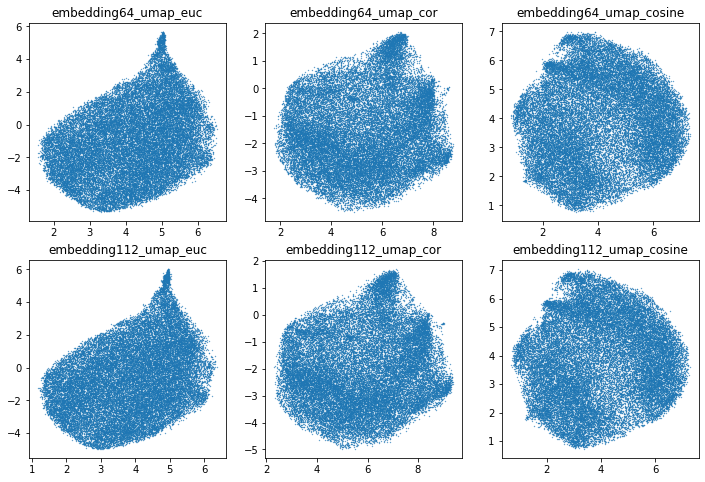

In [16]:
# ----Umap--------------------------------------------------------
## 檢視採用不同解析度(64、112)、距離計算方式(euclidean、correlation、cosine)轉換後的資料點分布
# img_size = ["64", "112"]
# dis_f = ["euc", "cor", "cosine"]
# path_EXAI =  "/home/jovyan/Autoencoder/EXAI_Visualization"

# fig, axes = plt.subplots(2,3, figsize=(12, 8))
# for i, rows in enumerate(axes):
#     for c, ax in enumerate(rows):
#         file = f"embedding{img_size[i]}_umap_{dis_f[c]}"
#         embedding = np.load(f"{path_EXAI}/umap/{file}.npy")
#         ax.scatter(embedding[:,0], embedding[:,1], s=.1)
#         ax.set_title(file)

In [30]:
%%time
# establish specie_mean-based embedding
species_list = np.sort(moth_meta.SciName.unique())
# get {specie : index}
species_index = {specie: moth_meta[moth_meta.SciName==specie].index.values for specie in species_list}

# img_size = ["64", "112"]
# dis_f = ["euc", "correlation", "cosine"]
# file = f"embedding{img_size[i]}_umap_{dis_f[c]}"
file = f"embedding112_umap_correlation"
embedding = np.load(f"{path_EXAI}/umap/{file}.npy")

embedding_means = [] 
for specie, index in species_index.items():
    embedding_mean = np.mean(embedding[index], axis=0)
    embedding_means.append(embedding_mean)
embedding_means = np.asarray(embedding_means)

print(embedding_means.shape)

(17186, 2)
CPU times: user 46.8 s, sys: 98.8 ms, total: 46.9 s
Wall time: 48.6 s


In [ ]:
# path_EXAI =  "/home/jovyan/Autoencoder/EXAI_Visualization"
# file = 'embedding112_pca'
# embedding_pca = np.load(f"{path_EXAI}/umap/{file}.npy")

In [27]:
import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [31]:
optics = OPTICS(
#     min_samples=10,
    xi=0.03,
    min_cluster_size= 50
)

labels = optics.fit_predict(embedding_means)

clustered = (labels >= 0)
print("size of  labels : ",np.unique(labels).size)
print(f"data be clustered : {100 * np.sum(clustered) / embedding_means.shape[0]: .2f} %")

size of  labels :  53
data be clustered :  21.22 %


size of  labels :  53
data be clustered :  21.22 %


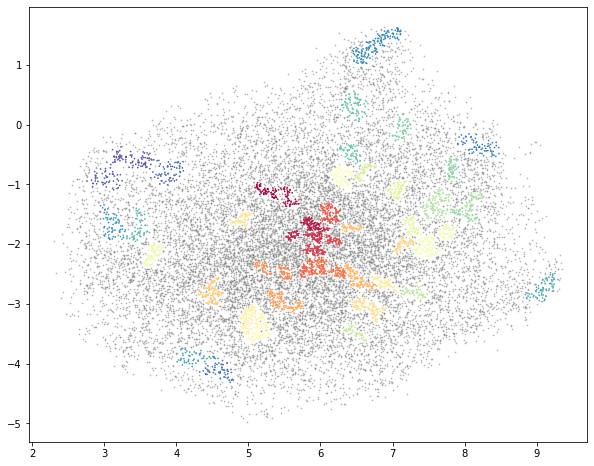

In [32]:
print("size of  labels : ",np.unique(labels).size)
print(f"data be clustered : {100 * np.sum(clustered) / embedding_means.shape[0]: .2f} %")
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.scatter(embedding_means[~clustered, 0],
            embedding_means[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.5,
            alpha=0.5)
ax.scatter(embedding_means[clustered, 0],
            embedding_means[clustered, 1],
            c=labels[clustered],
            s=0.5,
            cmap='Spectral');


#### 建立以種平均值為單位，進行分群
- 先將各標本照使用UMAP壓縮成二維，得到(n, 2)形狀的張量
- 將資料以物種為單位、取種平均
- 使用種平均、降維後的張量進行分群
  - 此處降維的目的只是為了後面分群計算節省運算量
    - 因此在使用umap時可以不限於壓縮至2維(壓縮至2、3維主要可便於視覺化理解)
    - 若使用pca則可直接設定想要獲得的解釋力來決定維數
        - e=0.9, n~=1200+； e=0.75，n=237 。  前者在儲存、分群運算時仍相當費工
        - 實測PCA降維分群結果相當不理想，因此捨棄
- 取得各群的index後， 直接對 Saliency vector取平均值，轉回2d後作圖
    - 分群是依物種均值，所以saliency vector也要轉換成以物種為單位
    - 分群結果其實是把距離相近的物種歸為同群，視覺化呈現該群中心點位置，顯示模型分科關注的重點區域
    - ~使用umap.inverse_transform，反轉回原本的向量維度(2D > 2*size 1D > size*size 2D)~


In [33]:
# 建立dict(class : index)- 建立dict(class : index)
cluster_index = {l : np.where(labels==l)[0] for l in np.unique(labels)}

# 建立以物種為單位的Saliency影像
imgs_means = np.asarray(
    [np.mean(imgs[index], axis=0) for specie, index in species_index.items()]
)
print(imgs_means.shape) 

# 依序按class所對應之index，計算saliency map的平均影像
cluster_means = np.asarray([np.mean(imgs_means[index], axis=0) for cluster, index in cluster_index.items()])
print(cluster_means.shape) 

(17186, 112, 112)
(53, 112, 112)


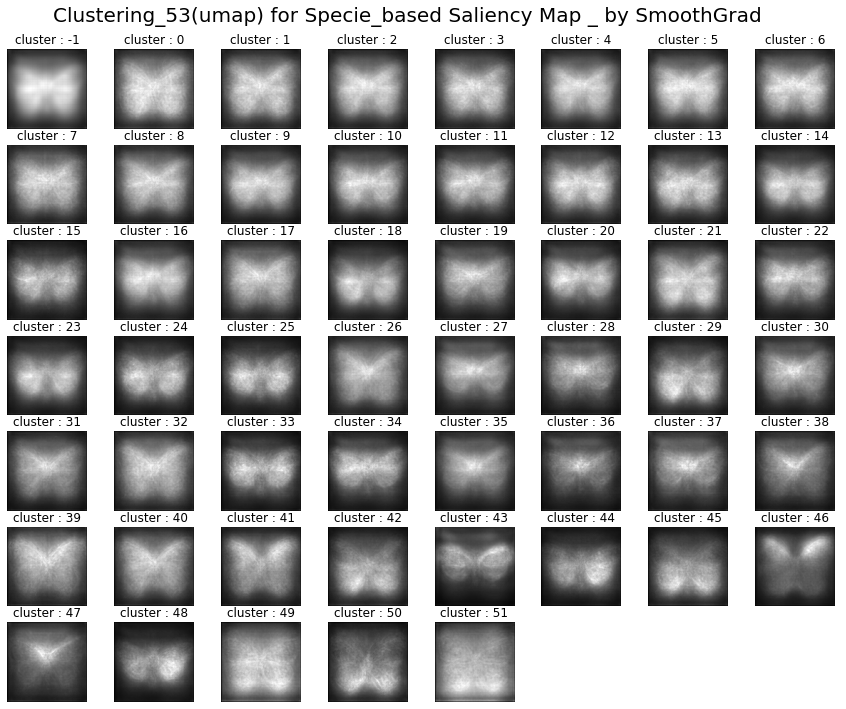

In [36]:
fig, axes = plt.subplots(7,8 ,figsize=(15, 12))
title = f"Clustering_{len(cluster_means)}(umap) for Specie_based Saliency Map _ by SmoothGrad"
fig.suptitle(title, fontsize=20, y=0.93 )
for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    if i < len(cluster_means):
        ax.set_title(f"cluster : {list(cluster_index.keys())[i]}")
        ax.imshow(cluster_means[i], cmap="gray")
    else:
        continue   
fig.savefig(f"{path_EXAI}/results/{title}.jpg", bbox_inches="tight")

#### 結果討論:
- 從分群的視覺化結果來看、分群效果並不明顯，可能並未找到所謂模型關注熱點
  - umap降維採用2D 或許增加維數可能效果會再好一點
- 最後Cluster中心點的SALIENCY MAP清楚與否，其實部分取決於該cluster採用的多少點，點越多越模糊
- 最後分群係數採用XI=0.03、分群用的參數 xi=0.03、 min_cluster_size= 50，得到53群、資料納入分群比例:21%
- CLUSTER -1 表示未被歸類於任何群的點，數量占總資料將近8成，因此影像最模糊
- 大部分可見模型關注部位再翅膀位置
  - 部分可較細緻的觀察到關注部位在翅膀的特定位置
  - 上方的比例尺在cluster 43 中似有出現